# Building a Web App to identify true and fake news.

I will work with CountVectorizer and Logistic Regression. In case Logistic Regression shouldn't provide good enough results I will check other models. I will try to automize the process with ColumnTransformer and Pipeline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import textwrap

pd.options.display.width = 0
pd.options.display.max_rows = None
pd.options.display.float_format = "{:.2f}".format

## Data pre-processing and analysis

In [2]:
fake_news_train = pd.read_csv("D:\\Coding_data\\fake_news_train.csv")
fake_news_test_nolabs = pd.read_csv("D:\\Coding_data\\fake_news_test.csv")
fake_news_submit = pd.read_csv("D:\\Coding_data\\fake_news_submit.csv")

In [3]:
print(fake_news_train.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [4]:
print(fake_news_test_nolabs.head())

      id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...  
1                      NaN  Russian warships ready to strike terrorists ne...  
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...  
3            Daniel Victor  If at first you don’t succeed, try a different...  
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...  


In [5]:
print(fake_news_submit.head())

      id  label
0  20800      0
1  20801      1
2  20802      0
3  20803      1
4  20804      1


Due to the fact that the test data and the test labels are in separated files I will first merge these two.

In [6]:
fake_news_test = pd.merge(fake_news_test_nolabs, fake_news_submit, on="id")

Lets check if we merged it correct? And yes all seems to be fine.

In [7]:
fake_news_test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


Let's have a quick look on the basic informations about the data:

In [8]:
fake_news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [9]:
fake_news_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
 4   label   5200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.8+ KB


So there are some missing values I suppose in 'title', 'author', 'text'. I will have a look on it.

In [10]:
fake_news_train['title'].isnull().sum()

558

In [11]:
fake_news_train[fake_news_train['title'].isnull()]

,id,title,author,text,label
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1
223,223,NaN,PhilSilversGhost,If I were one of those Guardsmen and the Spets...,1
288,288,NaN,beersession,The way he's doing business there seems he'll ...,1
490,490,NaN,curriec,"If so, then Hillary and Obama will end up bein...",1
535,535,NaN,beemasters,$4 Billion even after they are known to be kee...,1
541,541,NaN,Redlist Renegade,When the people fear their government there’s ...,1


In [12]:
no_title = fake_news_train[
    (fake_news_train['id'] == 10049)
]

In [13]:
for text in no_title['text']:
    print("\n---- Text if no title from article ID:\n\t", "\n".join(textwrap.wrap(text, width=100)))


---- Text if no title from article ID:
	 Israel.


So all listings without title are strange, it seems that they are kind of comments to articles or maybe tweets! We can notice that all of these cases are labeled with 1 - unreliable!!!

In [14]:
fake_news_train['author'].isnull().sum()

1957

In [15]:
fake_news_train[fake_news_train['author'].isnull()]

,id,title,author,text,label
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1
43,43,Can I have one girlfriend without you bastards...,NaN,Can I have one girlfriend without you bastards...,1
47,47,"СМИ Сербии приписали россиянам ""подготовку тер...",NaN,0 комментариев 0 поделились Фото: AP \nОднако ...,1
51,51,Dueling Drills Further Increase NATO Russia Te...,NaN,Dueling Drills Further Increase NATO Russia Te...,1
54,54,Samantha Bee Explores the Dangerous Rise of th...,NaN,Samantha Bee Explores the Dangerous Rise of th...,1
76,76,News: PR Disaster: The President Of Panasonic ...,NaN,Email \nGet ready for the most cringeworthy st...,1


In [16]:
no_author = fake_news_train[
    (fake_news_train['id'] == 1859)
]

In [17]:
for title in no_author['title']:
    print("\n---- Title if no author from article ID:\n\t", "\n".join(textwrap.wrap(title, width=100)))


---- Title if no author from article ID:
	 Стоит ли ожидать конца войны в Сирии? | Новое восточное обозрение


In [18]:
for text in no_author['text']:
    print("\n---- Text if no author from article ID:\n\t", "\n".join(textwrap.wrap(text, width=100)))


---- Text if no author from article ID:
	 Страна: Сирия В своей новой статье постоянный обозреватель НВО Тони Карталучи отмечает, что многие
до сих пор связывают надежды на окончание конфликта в Сирии с фигурой Дональда Трампа. Автор
напоминает, что агрессия против Дамаска является лишь частью более грандиозного плана по уничтожению
Ирана, который был запущен в действие Джорджем Бушем и затем подхвачен администрацией Барака Обамы.
И поскольку среди ближайших советников Трампа внимательный наблюдатель может заметить немало
неоконов, единственная надежда сирийского народа на мир продолжает таиться где-то на поле боя. С
полной версией статьи вы можете ознакомиться здесь . Популярные статьи


So here the author is unknown but still we have the title and the text. Noticable almost all of these articles are labeled with 1 - unreliable!!!

In [19]:
fake_news_train['text'].isnull().sum()

39

In [20]:
fake_news_train[fake_news_train['text'].isnull()]

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1


In [21]:
no_text = fake_news_train[
    (fake_news_train['id'] == 14499)
]

In [22]:
for title in no_text['title']:
    print("\n---- Title if no text from article ID:\n\t", "\n".join(textwrap.wrap(title, width=100)))


---- Title if no text from article ID:
	 Primaire – François Fillon se désiste au profit de Sarkzoy après la découverte d’une tête de cheval
dans son lit >> Le Gorafi


All cases without text are in french lenguage and they all are kind of signed with Le Gorafi. They all as well are labeled with 1 - unreliable!!!

We just checked train data and i the .info() of test data we see the same situation. I will leave it for the moment like that and go further with the data analysis.

I saw also that the data contains strings (articles) in different languages. Let's check it.

In [23]:
# fake_news_train_clear = fake_news_train[fake_news_train['title'].notna()]
# print(fake_news_train_clear.info())

<class 'pandas.core.frame.DataFrame'>

Int64Index: 20242 entries, 0 to 20799

Data columns (total 5 columns):

Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

0   id      20242 non-null  int64 

1   title   20242 non-null  object

2   author  18285 non-null  object

3   text    20203 non-null  object

4   label   20242 non-null  int64 

dtypes: int64(2), object(3)

memory usage: 948.8+ KB

In [24]:
# import spacy
# from spacy_langdetect import LanguageDetector
# from operator import itemgetter
# from collections import Counter

# nlp = spacy.load('en_core_web_sm')
# nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
# texts = fake_news_train_clean['title']

# languages = []

# for text in texts:
#   doc = nlp(text)
#   for sent in doc.sents:
#     languages.append(sent._.language)

# results = list(map(itemgetter('language'), languages))
# print(Counter(results))

Counter({'en': 26127, 'de': 1608, 'fr': 334, 'es': 331, 'ru': 262, 'UNKNOWN': 247, 'sv': 237, 'pt': 219, 'ca': 217, 'nl': 211, 'id': 211, 'it': 203, 'af': 196, 'tl': 192, 'so': 153, 'ro': 146, 'et': 142, 'no': 138, 'vi': 135, 'da': 105, 'cy': 97, 'fi': 71, 'pl': 68, 'sw': 66, 'tr': 59, 'lt': 42, 'hu': 36, 'hr': 32, 'ar': 31, 'bg': 25, 'sk': 16, 'sl': 14, 'mk': 14, 'cs': 13, 'lv': 13, 'uk': 7, 'sq': 5, 'el': 2, 'zh-cn': 1, 'fa': 1})

So I had to do it outside of anaconda cause they don't leave me to install spacy_langdetect.

But we see our languages, mostly here english, after long, long nothing and german as well as in smaller numbers other languages. Well is to say I had to remove NaN so it means 558 articles are not in the counting.

In [25]:
id_away = 'id'
fake_news_train = fake_news_train.drop(id_away, axis=1)
fake_news_test = fake_news_test.drop(id_away, axis=1)

Let's throw out all the NaN so that CountVectorizer can work with the data.

In [27]:
fake_news_train = fake_news_train.fillna(' ')
fake_news_test = fake_news_test.fillna(' ')

In [28]:
print(fake_news_train.info())
print(fake_news_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   author  20800 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5200 non-null   object
 1   author  5200 non-null   object
 2   text    5200 non-null   object
 3   label   5200 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 203.1+ KB
None


In [35]:
# fake_news_train.reset_index()
# fake_news_test.reset_index()

# print(fake_news_train.tail())
# print(fake_news_test.tail())

In [34]:
# throw_index = 'index'
# fake_news_train = fake_news_train.drop(throw_index, axis=1)
# fake_news_test = fake_news_test.drop(throw_index, axis=1)

# print(fake_news_train.tail())
# print(fake_news_test.tail())

Let's have a look the length of news in both train and test set.

In [40]:
import statistics

words_per_article_plot_train = fake_news_train["text"].apply(lambda x: len(x.split()))
stdev_train = statistics.stdev(words_per_article_plot_train)
words_per_article_train = words_per_article_plot_train.sum()/len(fake_news_train["text"])

words_per_article_plot_test = fake_news_test["text"].apply(lambda x: len(x.split()))
stdev_test = statistics.stdev(words_per_article_plot_test)
words_per_article_test = words_per_article_plot_test.sum()/len(fake_news_test["text"])

print ("The average number of words in train set news article is ", words_per_article_train)
print ("The average number of words in test set news article is ", words_per_article_test)

print ("The standard deviation in train set news article lengths is ", stdev_train)
print ("The standard deviation in test set news article lengths is ", stdev_test)

The average number of words in train set news article is  758.8825480769231
The average number of words in test set news article is  773.3794230769231
The standard deviation in train set news article lengths is  869.3328658898075
The standard deviation in test set news article lengths is  844.1962544923526


Text(0.5, 1.0, 'Number of Words in Test Set News Article')

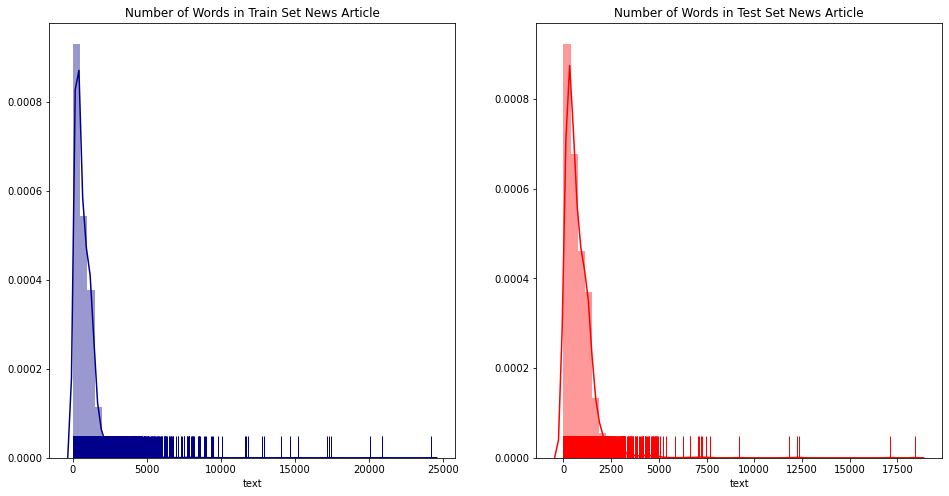

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.distplot(words_per_article_plot_train, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Train Set News Article")
sns.distplot(words_per_article_plot_test, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Test Set News Article")

News articles in test set are longer, on average, by 15 words. There is also more variance in their lengths, evidenced by a higher standard deviation and more articles on the right tail. There are some outliers, with some true and fake news articles being > 4000 words in length.

In [ ]:
words_per_article_plot_train = fake_news_train["text"].apply(lambda x: len(x.split()))
stdev_train = statistics.stdev(words_per_article_plot_train)
words_per_article_train = words_per_article_plot_train.sum()/len(fake_news_train["text"])

words_per_article_plot_test = fake_news_test["text"].apply(lambda x: len(x.split()))
stdev_test = statistics.stdev(words_per_article_plot_test)
words_per_article_test = words_per_article_plot_test.sum()/len(fake_news_test["text"])

print ("The average number of words in train set news article is ", words_per_article_train)
print ("The average number of words in test set news article is ", words_per_article_test)

print ("The standard deviation in train set news article lengths is ", stdev_train)
print ("The standard deviation in test set news article lengths is ", stdev_test)

## Building the model

Now all is ready. Let's split the data:

In [ ]:
predict = 'label'

X_train = fake_news_train.drop(predict, axis=1)
y_train = fake_news_train[predict].copy()

X_test = fake_news_test.drop(predict, axis=1)
y_test = fake_news_test[predict].copy()

In [ ]:
pd.value_counts(y_train)

In [ ]:
pd.value_counts(y_test)

In [ ]:
X_train.head()

I will preprocess data using ColumnTransformer CountVectorizer:

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer

preprocess = ColumnTransformer(
    [('cvect_title', CountVectorizer(), 'title'),
     ('cvect_author', CountVectorizer(), 'author'),
     ('cvect_text', CountVectorizer(), 'text')],
     remainder='passthrough')

In [ ]:
X_train_vectorized = preprocess.fit_transform(X_train)

### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

In [ ]:
lr = LogisticRegression(max_iter=300, random_state=42, n_jobs=-1)

In [ ]:
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(lr, X_train_vectorized, y_train, scoring="accuracy", cv=10)
lr_scores

In [ ]:
lr.fit(X_train_vectorized, y_train)

In [ ]:
X_test_vectorized = preprocess.transform(X_test)

lr_y_test_predict = lr.predict(X_test_vectorized)

In [ ]:
plot_confusion_matrix(lr, X_test_vectorized, y_test, values_format='.2f')

In [ ]:
lr_report = classification_report(y_test, lr_y_test_predict)
print("Classification report for LR:\n", lr_report)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

In [ ]:
nb_scores = cross_val_score(nb, X_train_vectorized, y_train, scoring="accuracy", cv=10)
nb_scores

In [ ]:
nb.fit(X_train_vectorized, y_train)

In [ ]:
plot_confusion_matrix(nb, X_test_vectorized, y_test, values_format='.2f')

In [ ]:
nb_y_test_predict = nb.predict(X_test_vectorized)

In [ ]:
nb_report = classification_report(y_test, nb_y_test_predict)
print("Classification report for NB:\n", nb_report)

### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(random_state=42)

In [ ]:
svm_scores = cross_val_score(svm, X_train_vectorized, y_train, scoring="accuracy", cv=10)
svm_scores

In [ ]:
svm.fit(X_train_vectorized, y_train)

In [ ]:
plot_confusion_matrix(svm, X_test_vectorized, y_test, values_format='.2f')

In [ ]:
svm_y_test_predict = svm.predict(X_test_vectorized)

In [ ]:
svm_report = classification_report(y_test, svm_y_test_predict)
print("Classification report for SVM:\n", svm_report)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
rf_scores = cross_val_score(rf, X_train_vectorized, y_train, scoring="accuracy", cv=10, n_jobs=-1)
rf_scores

In [ ]:
rf.fit(X_train_vectorized, y_train)

In [ ]:
plot_confusion_matrix(rf, X_test_vectorized, y_test, values_format='.2f')

In [ ]:
rf_y_test_predict = rf.predict(X_test_vectorized)

In [ ]:
rf_report = classification_report(y_test, rf_y_test_predict)
print("Classification report for RF:\n", rf_report)

In [ ]:
rf_param_grid = [
    {'n_estimators': [10, 15, 20, 50, 100, 200, 300], 
     'max_depth': [50, 60, 70]}
]

rf_grid = GridSearchCV(rf, rf_param_grid, cv=10, scoring='accuracy')
rf_grid.fit(X_train_vectorized, y_train)
rf_grid.best_params_

So best parameters for the classifier would be as seen by GridSearch. So this is our model:

In [ ]:
model = RandomForestClassifier(max_depth=70, n_estimators=300, random_state=42, n_jobs=-1)

## Evaluating the model

In [ ]:
model.fit(X_train_vectorized, y_train)

In [ ]:
y_predict = model.predict(X_test_vectorized)

In [ ]:
plot_confusion_matrix(model, X_test_vectorized, y_test, values_format='.2f')

In [ ]:
model_report = classification_report(y_test, y_predict)
print("Classification report for Model:\n", model_report)

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.nlargest(20).plot(kind='barh')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [ ]:
auc = roc_auc_score(y_test, model.predict_proba(X_test_vectorized)[:,1])
print("AUC score:\n", auc)

And some plots of:

-precision vs recall curve

-roc curve

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_predict)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [ ]:
fpr, tpr, threshs = roc_curve(y_test, y_predict)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## Testing the model

ok. So let's see how my model will do with brand actuell news. Quite interessting!

In [ ]:
X_test_1_d = {'title': ["""Belgium surge likened to tsunami"""],
        'author': ["""Gavin Lee"""],
        'text': ["""
        "We are close to a tsunami": that was the stark warning on the gravity of the situation in Belgium, from health minister Frank Vandenbroucke.
He told reporters that a “tsunami” would be a scenario where “we no longer control what is happening". The health pressures in Brussels and the southern French-speaking Wallonia region were “the most dangerous in all of Europe”, he said.
Belgium is now recording on average almost 8,000 cases a day. Most are in Brussels and Liège. That figure is four times higher than the daily average only two weeks ago.
In the past three days, more than 10,000 daily cases were recorded.
The death rate is also slowly rising again, at around 30 per day. But that is still 10 times less than at the peak of the first wave, when Belgium had the world’s highest coronavirus death rate per capita.
There is concern over medical staff and their ability to cope with an influx of cases. Several hospitals in Brussels and Liège have started sending patients elsewhere to avoid saturation. In some cases hospitals in Aalst and Charleroi refused to accept new Covid patients. The mayor of Aalst, Christophe D’Haese, said “the limits of medical solidarity" had been reached.
Doctors' surgeries are also feeling the strain. On Friday, I called my GP for a check-up and was told to avoid coming in because the chance of contracting coronavirus was too high. The doctor said the place was “an aquarium of Covid cases”. Authorities here blame the spread on “pandemic fatigue” - people becoming complacent and no longer observing social distancing rules.
                 """]
        }
X_test_1 = pd.DataFrame(X_test_1_d, columns = ['title', 'author', 'text'])

y_test_1 = pd.DataFrame({0}, columns = ['label'])

X_test_1_vectorized = preprocess.transform(X_test_1)

prediction_test_1 = model.predict(X_test_1_vectorized)

if prediction_test_1:
  print("Look out!!! You should not take this news seriously, it's not trustfull!")
else:
  print("Great!!! You can read this news, it is trustfull!")

In [ ]:
prediction_test_1_a = model.predict_proba(X_test_1_vectorized)
prediction_test_1_a

In [ ]:
X_test_2_d = {'title': ["""What does 'no-deal' Australia-style Brexit mean?"""],
        'author': ["""Chris Morris"""],
        'text': ["""
        Remember how this time last year we were talking about a no-deal Brexit? Well, it's back.
It is not exactly the same thing, because the UK left the European Union (EU) on 31 January.
The UK is now in a transition period with the EU until the end of the year, which means it is still following EU rules and trade stays the same. The transition was designed to give both sides a bit of time to negotiate a future trade agreement.
But if there is no trade deal by 31 December, the UK would automatically fall back on the rules of the World Trade Organization (WTO).
The government now refers to this outcome as an "Australia-style deal" (Australia trades with the EU largely on WTO rules) but - as Business Secretary Alok Sharma admits - the difference between no deal and an Australia deal is "a question of semantics at the end of the day".
What is the WTO?
The WTO is the place where countries negotiate the rules of international trade - there are 164 members and if they don't have free-trade agreements with each other, they trade under basic "WTO rules".
Every member has a list of tariffs (taxes on imports of goods) and quotas (limits on the number of goods) that they apply to other countries with which they don't have a deal. These are known as WTO schedules.
How does trade with the EU work now?
The EU is the UK's biggest single trading partner. In 2019, it accounted for:
43% of UK exports
51% of UK imports
As an EU member, the UK was part of its trading system - the customs union and the single market. This meant there were no tariffs on goods traded between the two, and minimal border checks.
This arrangement continues until the end of the transition period.
The two sides have been trying to reach a new free-trade agreement, which would get rid of tariffs and quotas but not new border bureaucracy. But the time to do that is fast running out.
Don't other countries trade with the EU on WTO rules?
Yes, examples include the United States and China, Brazil and Australia.
In fact, it's any country with which the EU has not signed a free-trade deal. That's when WTO rules kick in.
But those big economies don't just rely on basic WTO rules - they have all done other deals with the EU to help facilitate trade.
The US, for example, has at least 20 agreements with the EU that help regulate specific sectors, covering everything from wine and bananas to insurance and energy-efficiency labelling.
Australia also has such agreements, including a 2008 deal that made it easier for Australian wine to access European markets.
An Australia-style deal?
So, the "Australia-style deal" being talked about by the government would mean the UK trading with the EU in roughly the same way Australia does.
But there are no guarantees that side deals covering specific sectors would be done before the end of the year, so it amounts to the same thing as leaving without any trade agreement, and trading on WTO rules.
It's also important to consider geography, and volume of trade.
Australia is on the other side of the world, whereas the UK is the EU's next-door neighbour. That means Australia doesn't do nearly as much trade with the EU as the UK does.
And it doesn't rely on the EU in the way the UK does, for the operation of just-in-time supply chains in sectors such as cars, pharmaceuticals and food.
In other words, border checks and delays have far less impact on EU-Australia trade than they would on EU-UK trade.
It's also worth nothing that Australia wants to improve its trading relationship with the EU - the two sides have been negotiating a free trade deal since 2018.
Why is the government also talking about a Canada-style deal?
The government has said repeatedly that it wants a free-trade deal along the lines of the one the EU has with Canada.
What is a 'Canada-style' trade deal?
The UK and the EU have been trying to negotiate an agreement that would have no tariffs or quotas at all.
                 """]
        }
X_test_2 = pd.DataFrame(X_test_2_d, columns = ['title', 'author', 'text'])

y_test_2 = pd.DataFrame({0}, columns = ['label'])

X_test_2_vectorized = preprocess.transform(X_test_2)

prediction_test_2 = model.predict(X_test_2_vectorized)

if prediction_test_2:
  print("Look out!!! You should not take this news seriously, it's not trustfull!")
else:
  print("Great!!! You can read this news, it is trustfull!")

In [ ]:
prediction_test_2_a = model.predict_proba(X_test_2_vectorized)
prediction_test_2_a

In [ ]:
X_test_3_d = {'title': ["""Master of the Universe Controls *90%* of Online Searches"""],
        'author': ["""Lucas Nolan"""],
        'text': ["""
        The Justice Department has filed its long-awaited antitrust lawsuit against Google, 
        alleging that the Big Tech Masters of the Universe engaged in anticompetitive practices to preserve its monopoly 
        power and crush competitors to its search and advertising businesses. The Wall Street Journal first broke the story 
        on Tuesday morning that the lawsuit would finally be filed.
        According to a report by Reuters, the DOJ has filed its hotly-anticipated antitrust lawsuit against Google. 11 states 
        also joined the DOJ action against the internet giant.
        The Reuters report confirms the news this morning from the Wall Street Journal that the Justice Department would 
        file an antitrust lawsuit against tech giant Google today, claiming that the company engaged in anticompetitive practices
        in order to preserve monopolies in the search and advertising components that make up huge sections of the tech firm’s 
        main 
        business.
        Breitbart News previously reported that the Justice Department has been planning to bring an antitrust case against
        Google for some time. The recent filing comes after Attorney General William P. Barr reportedly overruled lawyers 
        who said they needed more time to build a case against the tech giant.
It was reported that the company has been under investigation for almost a year with dozens of Justice Department
lawyers working in two groups, each overseeing a separate line of inquiry. The two main areas being investigated were 
Google’s dominance in search and the company’s control over the online advertising ecosystem.
Google has control over approximately 90 percent of web searches worldwide, many rivals have complained that  Google extends 
its dominance by making its search and browsing tools defaults on phones running its Android operating system.
                 """]
        }
X_test_3 = pd.DataFrame(X_test_3_d, columns = ['title', 'author', 'text'])

y_test_3 = pd.DataFrame({1}, columns = ['label'])

X_test_3_vectorized = preprocess.transform(X_test_1)

prediction_test_3 = model.predict(X_test_3_vectorized)

if prediction_test_3:
  print("Look out!!! You should not take this news seriously, it's not trustfull!")
else:
  print("Great!!! You can read this news, it is trustfull!")

In [ ]:
prediction_test_3_a = model.predict_proba(X_test_3_vectorized)
prediction_test_3_a

In [ ]:
X_test_4_d = {'title': ["""Trump Attempts To Soften Image Before Election By Adopting Dead Dog"""],
        'author': [""""""],
        'text': ["""
        WASHINGTON—Flopping the putrescent animal carcass down in the Oval Office with an introduction of “call 
        him whatever you want, I don’t care,” President Donald Trump announced Monday that the first family had a new 
        member, a dead dog reportedly adopted to soften his image before election day. “I saw this on the side of the road 
        and I told the Secret Service, ‘Stop the motorcade, that’s it, that’s a brilliant idea, it’s gonna be perfect,’” 
        said Trump as he grabbed an ear to lift up the limp, withered remains of the golden retriever, allowing the media 
        to capture a few images of the deceased canine before its ear tore away, its body fell at his feet, and its head 
        rolled down a limestone walkway in a puddle of blood and brain matter. “That’s good, lie down. And stay down, okay? 
        They say if you want a friend in Washington, get one of these—of course, I have friends already, so many friends, 
        but here it is anyway. Here’s a dog. Everyone says this breed is very loyal, so we’ll see, we’ll see. Could become 
        the best dog any president has ever had. I’m told it has a great pedigree, and I’m expecting great things.” At 
        press time, Trump was seen kicking the dead dog’s head down the West Wing Colonnade after internal polling showed 
        its approval rating was higher than his.
                 """]
        }
X_test_4 = pd.DataFrame(X_test_4_d, columns = ['title', 'author', 'text'])

y_test_4 = pd.DataFrame({1}, columns = ['label'])

X_test_4_vectorized = preprocess.transform(X_test_1)

prediction_test_4 = model.predict(X_test_4_vectorized)

if prediction_test_3:
  print("Look out!!! You should not take this news seriously, it's not trustfull!")
else:
  print("Great!!! You can read this news, it is trustfull!")

In [ ]:
prediction_test_4_a = model.predict_proba(X_test_4_vectorized)
prediction_test_4_a

## Pickling model for deployment

In [ ]:
import pickle

pickle.dump(model, open("fake_news_model.sav", "wb"))
pickle.dump(preprocess, open("preprocess.sav", "wb"))